In [1]:
import numpy as np
import json as js
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from sklearn.decomposition import PCA

from nona.nona import nona

In [4]:
#load data


base_dir = "c:\\Users\\1\\Desktop\\datasets"
def data_loader(max_data=None, start_position=0, base_dir=None, base_file_path=None):

    data_buffer = {}

    if base_dir is not None and (base_file_path is None or base_file_path is not None):

        if max_data is None:

            raise ValueError("[max_data is a reguared param] !!!")
        
        for json_file in os.listdir(base_dir)[:-1]:

            print(json_file)
            curent_file = os.path.join(base_dir, json_file)
            curent_data_buffer = {}
            with open (curent_file) as file:

                json_data = file.readlines()
                json_data = json_data[start_position: max_data]

                for (json_number, json_per_line) in enumerate(json_data):
                    
                
                    json_format = js.loads(json_per_line)
                    curent_data_buffer[f"subject_number: {json_number}"] = json_format
            
            data_buffer[json_file] = curent_data_buffer


        person_id_list = []
        for data_batch in data_buffer.keys():
            for subject in data_buffer[data_batch].keys():

                person_id_list.append(data_buffer[data_batch][subject]["profile_id"])


        person_log_file = os.path.join(base_dir, os.listdir(base_dir)[-1])
        person_info_buffer = {}

        with open(person_log_file) as file:

            json_data = file.readlines()
            for (json_number, json_per_line) in enumerate(json_data):

                json_format_data = js.loads(json_per_line)
                if json_format_data["id"] in person_id_list:

                    person_info_buffer[json_format_data["id"]] = json_format_data
        
        return data_buffer, person_info_buffer


    elif base_dir is None and base_file_path is not None:

        with open(base_file_path, "r") as json_file:

            data_buffer = js.load(json_file)
            return data_buffer

    elif base_dir is None and base_file_path is not None:

        raise ValueError("[both datasets paths are none] !!!")
        

        

data_buffer, person_info_buffer = data_loader(base_dir=base_dir, max_data=2000)

test_input_samples = data_loader(base_file_path="C:\\Users\\1\\Desktop\\ItPLanetProject2\\input-sample.json")

print(type(test_input_samples["sessions"][0]["skllzz_with_artifacts"]))
keys = [key for key in person_info_buffer.keys()]
print(person_info_buffer)
print()




activity_step_cheaters.jsonl
activity_step_ok.jsonl
<class 'float'>
{'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE': {'id': 'SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE', 'birth_date': 800, 'hr_rest': 60, 'hr_max': 170, 'sex': 'female', 'weight': 76}, '0Vp2-U6casaZDBBbHDi_51q5zYC9lZid7H9bum77HZE': {'id': '0Vp2-U6casaZDBBbHDi_51q5zYC9lZid7H9bum77HZE', 'birth_date': 5600, 'hr_rest': 60, 'hr_max': 182, 'sex': 'female', 'weight': 56, 'personal_goals': ['lose_weight', 'strength', 'fun']}, 't5vblCvdKjZ2GfwvSoUwSUZUunZbkDJqyeLOEaR7qLM': {'id': 't5vblCvdKjZ2GfwvSoUwSUZUunZbkDJqyeLOEaR7qLM', 'birth_date': 1000, 'hr_rest': 60, 'hr_max': 169, 'sex': 'male', 'weight': 80, 'personal_goals': ['lose_weight']}, 'xQKE2ckX5kuzFAuiAixCOTIO3LJearvJTS1BjUVHTAU': {'id': 'xQKE2ckX5kuzFAuiAixCOTIO3LJearvJTS1BjUVHTAU', 'birth_date': 6400, 'hr_rest': 60, 'hr_max': 185, 'sex': 'male', 'weight': 90, 'personal_goals': ['strength', 'antistress', 'body_balance']}, 'OwSCFm0D2644sgzSF8zg_lplcTd735HwKcE9L8EwmDA': {'id':

In [5]:
def generate_input_samples(data_buffer):

    profile = data_buffer["profile"]
    sessions = data_buffer["sessions"]

    result_data = []
    profile_info = [float(profile[feature]) for feature in profile.keys() if feature not in ["sex", "id", "personal_goals"]]
    
    for session in sessions:
        
        min_variation = 1000000000000
        session_samples = np.asarray([[float(sample[feature]) for feature in sample.keys() if feature != "duration"] for sample in session["steps"]["samples"]])
        mean_vector = np.asarray([np.mean(session_samples[:, vector_number]) for vector_number in range(session_samples.shape[1])])

        optim_vector = np.zeros(shape=mean_vector.shape)

        session_general_data = [float(session[feature]) for feature in session.keys() if feature not in ["steps", "id", "timezone", "profile_id"]]
        session_general_data[0] /= 360

        session_steps_data = [float(session["steps"][feature]) for feature in session["steps"].keys() if feature != "samples"]
        session_steps_data[0] *= 3.6e+6
        session_steps_data[1] *= 3.6e+6

        for curent_vector in session_samples:

        
            if min_variation > np.dot(curent_vector, mean_vector):
                
                min_variation = np.dot(curent_vector, mean_vector)
                optim_vector = curent_vector
        
        optim_vector = list(optim_vector)
        optim_vector[0] *= 3.6e+6

        optim_vector += (session_general_data + session_steps_data + profile_info)
        result_data.append(optim_vector)
    
    result_data = np.asarray(result_data)
    return result_data


test_input_data = generate_input_samples(data_buffer=test_input_samples)
print(test_input_data, test_input_data.shape)
            







[[0.0000000e+00 0.0000000e+00 4.7390100e+09 1.7061300e+12 9.3200000e-01
  6.9900000e+00 1.4840000e+03 9.3200000e-01 9.3200000e-01 8.3880000e+08
  7.1085600e+10 1.8400000e+02 1.0800000e+04 6.0000000e+01 1.9600000e+02
  6.0000000e+01]
 [0.0000000e+00 0.0000000e+00 4.7392500e+09 1.7062164e+12 3.6644000e+01
  2.7483000e+02 1.4850000e+03 3.6644000e+01 3.6644000e+01 3.2979600e+10
  7.1089200e+10 7.2020000e+03 1.0800000e+04 6.0000000e+01 1.9600000e+02
  6.0000000e+01]
 [0.0000000e+00 0.0000000e+00 4.7394900e+09 1.7063028e+12 1.8568000e+01
  1.3926000e+02 1.4860000e+03 1.8568000e+01 1.8568000e+01 1.6711200e+10
  7.1092800e+10 3.6490000e+03 1.0800000e+04 6.0000000e+01 1.9600000e+02
  6.0000000e+01]
 [0.0000000e+00 0.0000000e+00 4.7397300e+09 1.7063892e+12 1.5096000e+01
  1.1322000e+02 1.4870000e+03 1.5096000e+01 1.5096000e+01 1.3586400e+10
  7.1096400e+10 2.9670000e+03 1.0800000e+04 6.0000000e+01 1.9600000e+02
  6.0000000e+01]
 [0.0000000e+00 0.0000000e+00 4.7399700e+09 1.7064756e+12 3.2512000e

In [6]:
def generate_data_frame(data_buffer, person_info_buffer):

    data_list = [] 
    subjects_features = ["start_millis", "stop_millis", "skllzz", 
                             "activity_day", "skllzz_with_artifacts", "skllzz_without_artifacts", 
                             "steps", "day", "meters", 
                             "birth_date", "hr_rest", "hr_max", 
                             "weight", "kkal"]
    
    for (batch_number, data_batch) in enumerate(data_buffer):

        print(data_batch)
        sub_info = []
        subjects = [key for key in data_buffer[data_batch].keys()]
        subjects_id = [data_buffer[data_batch][subject]["profile_id"] for subject in subjects]

        for feature in subjects_features:
            
            subject_feature_list = []
            for (subject, subject_id) in zip(subjects, subjects_id):
                
                if feature in ["day", "meters", "steps"]:

                    if feature in data_buffer[data_batch][subject]["steps"].keys():
                        subject_feature_list.append(float(data_buffer[data_batch][subject]["steps"][feature]))

                    else:
                        subject_feature_list.append(0.0)
                
                elif feature in ["hr_max", "hr_rest", "weight", "birth_date"]:

                    if feature in person_info_buffer[subject_id].keys():
                        subject_feature_list.append(float(person_info_buffer[subject_id][feature]))
                    
                    else:
                        subject_feature_list.append(0.0)
                
                elif feature in ["stop_millis", "start_millis"]:

                    if feature in data_buffer[data_batch][subject].keys():
                        
                        formated_millis = float(data_buffer[data_batch][subject][feature]) * 3.6e+6
                        subject_feature_list.append(formated_millis)

                    else:
                        subject_feature_list.append(0.0)

                else:

                    if feature in data_buffer[data_batch][subject].keys():
                        subject_feature_list.append(float(data_buffer[data_batch][subject][feature]))
                    
                    else:
                        subject_feature_list.append(0.0)
            
            sub_info.append(subject_feature_list)
        sub_info_tensor = np.asarray(sub_info, dtype="float32")
        


        for (subject_number, subject) in enumerate(data_buffer[data_batch].keys()):

            add_vector = list(sub_info_tensor[:, subject_number]) + [batch_number, ]

            if "samples" in data_buffer[data_batch][subject]["steps"].keys():

                min_var = 1000000000000000000000000000
                samples_data = np.asarray([[float(sample[feature]) for feature in sample.keys() if feature != "duration"] for sample in data_buffer[data_batch][subject]["steps"]["samples"]])
                mean_vector = [np.mean(samples_data[:, vector_number]) for vector_number in range(samples_data.shape[1])]
                optim_vector = None

                for sample in data_buffer[data_batch][subject]["steps"]["samples"]:
                    
                    sample_vector = np.asarray([float(sample[feature]) for feature in sample.keys() if feature != "duration"])
                    if min_var > (np.dot(sample_vector, mean_vector)):

                        min_var = (np.dot(sample_vector, mean_vector))
                        optim_vector = list(sample_vector)


                optim_vector += add_vector
                optim_vector = np.asarray(optim_vector)
                optim_vector[0] *= 3.6e+6


            else:
                optim_vector = [0.0, 0.0] + add_vector
            
            data_list.append(optim_vector)



    all_features = ["stamp_millis", "steps"] + subjects_features + ["class_labels", ]
    data_tensor = np.asarray(data_list)
    data_frame = pd.DataFrame(data=data_tensor,
                              columns=all_features)
    
    return (data_frame, data_tensor)
    

data_frame, data_tensor = generate_data_frame(data_buffer=data_buffer, person_info_buffer=person_info_buffer)
print(data_tensor.shape)
            

activity_step_cheaters.jsonl
activity_step_ok.jsonl
(4000, 17)


[[-0.00499195  0.22466687  0.65620563 -0.9854954   1.54407225 -1.42922933
  -1.19755903 -0.26082738 -1.20765831 -0.21640396 -0.20409257 -0.68861104
   1.19710409  1.25699     0.27355025  0.51222098 -0.04516732  0.6667069
  -0.7009988  -0.84286747 -0.63123378 -0.80532113  0.71995772 -0.90377229
  -0.59386371 -0.42601427 -1.10411887 -0.13779659  0.19073945  2.54325769
   1.21199828  0.30406516  0.44187807 -0.70027869]
 [-0.00356918  0.22777892  0.66248301 -0.99124441  1.55683018 -1.43820073
  -1.2048617  -0.26126521 -1.21502823 -0.21654012 -0.20412047 -0.69216845
   1.20731026  1.26764721  0.27699725  0.51743262 -0.0440239   0.67304609
  -0.70466102 -0.84754825 -0.63437431 -0.80973095  0.7266942  -0.90892052
  -0.59675404 -0.42765244 -1.11070626 -0.13733393  0.19361248  2.56329507
   1.22231724  0.3077587   0.44658152 -0.70393827]
 [-0.00348956  0.22795624  0.66284197 -0.99157293  1.55755567 -1.43870891
  -1.2052792  -0.26128972 -1.21544852 -0.21655134 -0.20412249 -0.69236896
   1.207888

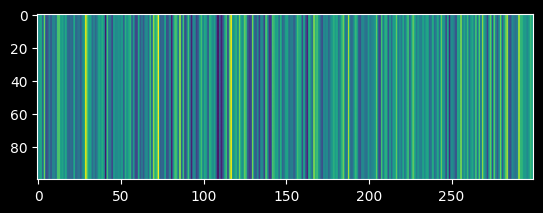

In [95]:
def expand_randomization(data_tensor, need_shape):

    
    permutated_data_tensor = np.random.permutation(data_tensor)
    random_normal_distrib = np.random.normal(0.19, 1.926, ((permutated_data_tensor.shape[1] - 1), need_shape))
    result_expand = np.dot(permutated_data_tensor[:, :-1], random_normal_distrib)
    result_expand_std = (result_expand - np.mean(result_expand)) / np.std(result_expand)

    result_tensor = np.zeros(shape=(result_expand.shape[0], result_expand.shape[1] + 1))
    result_tensor[:, :-1] = result_expand_std
    result_tensor[:, -1] = permutated_data_tensor[:, -1]

    print(result_tensor[:3, :34])
    return result_tensor

    

preprocessed_data = expand_randomization(data_tensor, need_shape=800)

train_data = preprocessed_data[:preprocessed_data.shape[0] // 2, :-1]
validation_data = preprocessed_data[preprocessed_data.shape[0] // 2: -1, :-1]

train_label = preprocessed_data[:preprocessed_data.shape[0] // 2, -1]
validation_label = preprocessed_data[preprocessed_data.shape[0] // 2: -1, -1]



plt.imshow(preprocessed_data[:100, :300], cmap="viridis")


    

In [101]:
input_tensor = tf.keras.Input(shape=(train_data.shape[1], ))

print(train_data.shape)

layer = tf.keras.layers.Dense(800, 
                              input_shape=(preprocessed_data.shape[0], ), 
                              activation="relu",
                              activity_regularizer=tf.keras.regularizers.L1(0.01),
                              kernel_regularizer=tf.keras.regularizers.L2(0.01))(input_tensor)

layer = tf.keras.layers.Dense(255, 
                              activation="relu",
                              activity_regularizer=tf.keras.regularizers.L1(0.01),
                              kernel_regularizer=tf.keras.regularizers.L2(0.01))(layer)

layer = tf.keras.layers.Dense(100,
                             activation="relu",
                             activity_regularizer=tf.keras.regularizers.L1(0.01),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01))(layer)

layer = tf.keras.layers.Dense(32,
                             activation="relu",
                             activity_regularizer=tf.keras.regularizers.L1(0.01),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01))(layer)

#layer = tf.keras.layers.Dropout(0.5)(layer)
last_layer = tf.keras.layers.Dense(1, activation="sigmoid")(layer)

model = tf.keras.Model(input_tensor, last_layer)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


(2000, 800)


In [102]:
print(train_data.shape, train_label.shape)
print(validation_data.shape, validation_label.shape)
model_history = model.fit(train_data, train_label,
                          epochs=100,
                          batch_size=30,
                          validation_data=(validation_data, validation_label))

#model.save("C:\\Users\\1\\Desktop\\ItPLanetProject2\\SavedModels\\first_model.keras")


(2000, 800) (2000,)
(1999, 800) (1999,)
Epoch 1/100


67/67 [==============================] - 2s 16ms/step - loss: 5.7100 - accuracy: 0.5045 - val_loss: 1.5284 - val_accuracy: 0.4917
Epoch 2/100
67/67 [==============================] - 1s 16ms/step - loss: 0.9415 - accuracy: 0.5085 - val_loss: 0.7309 - val_accuracy: 0.4917
Epoch 3/100
67/67 [==============================] - 1s 14ms/step - loss: 0.7062 - accuracy: 0.5085 - val_loss: 0.6948 - val_accuracy: 0.4917
Epoch 4/100
67/67 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5085 - val_loss: 0.6933 - val_accuracy: 0.4917
Epoch 5/100
67/67 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6934 - val_accuracy: 0.4917
Epoch 6/100
67/67 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6934 - val_accuracy: 0.4917
Epoch 7/100
67/67 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6934 - val_accuracy: 0.4917
Epoch 8/100
67/67 

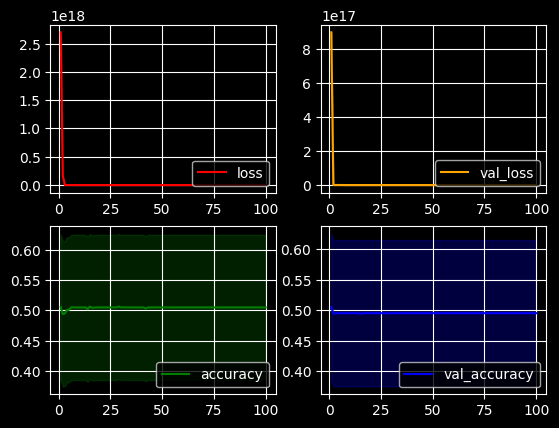

In [91]:
model_stats = [[np.asarray(model_history.history["loss"]), np.asarray(model_history.history["val_loss"])], 
          [np.asarray(model_history.history["accuracy"]), np.asarray(model_history.history["val_accuracy"])]]

def show_results(model_data):

    labels = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]
    colors = [["red", "orange"], ["green", "blue"]]

    plt.style.use("dark_background")
    fig, axis = plt.subplots(nrows=2, ncols=2)
    for sample in range(len(axis)):

        axis[sample][0].plot(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0], color=colors[sample][0], label=labels[sample][0])
        axis[sample][0].fill_between(range(1, model_stats[sample][0].shape[0] + 1), model_stats[sample][0] - 0.12, model_stats[sample][0] + 0.12, color=colors[sample][0], alpha=0.25)
        
        axis[sample][1].plot(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1], color=colors[sample][1], label=labels[sample][1])
        axis[sample][1].fill_between(range(1, model_stats[sample][1].shape[0] + 1), model_stats[sample][1] - 0.12, model_stats[sample][1] + 0.12, color=colors[sample][1], alpha=0.25)

        axis[sample][0].legend(loc="lower right")
        axis[sample][0].grid()
        
        axis[sample][1].legend(loc="lower right")
        axis[sample][1].grid()

    plt.show()

show_results(model_data=model_stats)

In [92]:

test_data_buffer, test_person_info_buffer = data_loader(base_dir="c:\\Users\\1\\Desktop\\datasets", start_position=2000, max_data=4000)
test_data_tensor = generate_data_frame(test_data_buffer, test_person_info_buffer)

test_data_frame, test_data_tensor = generate_data_frame(test_data_buffer, test_person_info_buffer)

test_preprocessed_data = expand_randomization(test_data_tensor, need_shape=100)

test_train_data = test_preprocessed_data[:test_preprocessed_data.shape[0] // 2, :-1]
test_train_labels = test_preprocessed_data[:test_preprocessed_data.shape[0] // 2, -1]

test_validation_data = test_preprocessed_data[test_preprocessed_data.shape[0] // 2:, :-1] 
test_validation_labels = test_preprocessed_data[test_preprocessed_data.shape[0] // 2:, -1]

predicted_data = model.predict(test_train_data)
chiters_number = 0
none_chiters_number = 0
errors_count = 0
true_prediction_count = 0

for (prediction_number, prediction) in enumerate(predicted_data):

    if prediction[0] > 0.55:
      
      if test_train_labels[prediction_number] == 0.0:
          errors_count += 1
      
      else:
         true_prediction_count += 1

      print(f"subject number: [{prediction_number}] is chiter with probability: [{prediction[0]}], and it's true label is: [{test_train_labels[prediction_number]}]")
      chiters_number += 1
    
    else:
      
      if test_train_labels[prediction_number] == 1.0:
          errors_count += 1
      
      else:
         true_prediction_count += 1

      print(f"subject number: [{prediction_number}] is chiter with probability: [{prediction[0]}], and it's true label is: [{test_train_labels[prediction_number]}]")
      none_chiters_number += 1
    

print(f"Total chiters number: [{chiters_number}], Total none chiters number: [{none_chiters_number}], Total prediction errors: [{errors_count}], Total prediction trues: [{true_prediction_count}]")
      




activity_step_cheaters.jsonl
activity_step_ok.jsonl
activity_step_cheaters.jsonl
activity_step_ok.jsonl
activity_step_cheaters.jsonl
activity_step_ok.jsonl
[[ 7.73278080e+18 -2.40455129e+18  1.31946471e+19  1.82009019e+19
   4.08075400e+18 -2.94339584e+19  2.35507864e+19  2.36409561e+19
   3.97292352e+19  1.02561111e+19  2.57587699e+19 -1.26355266e+19
  -7.99272930e+18 -5.41315276e+18  1.23202641e+19  2.87866479e+19
  -2.08560339e+19  4.76445833e+19  4.53368703e+19 -1.07805918e+19
   8.78806320e+18  1.08197009e+18 -2.61381549e+19 -2.91945792e+19
   6.56889650e+18  1.59401150e+19 -2.38495728e+19  4.89033920e+19
   4.61045331e+19  2.28354476e+19  1.64817219e+19 -1.33587575e+17
   1.80406249e+19  2.75102532e+19]
 [ 7.74986002e+18 -2.41000431e+18  1.32235989e+19  1.82409101e+19
   4.08964119e+18 -2.94982098e+19  2.36023743e+19  2.36928420e+19
   3.98162230e+19  1.02786080e+19  2.58152887e+19 -1.26632639e+19
  -8.01007205e+18 -5.42508517e+18  1.23471152e+19  2.88495935e+19
  -2.09017432e+19